In [47]:
import pandas as pd
import numpy as np
import os
import pickle

from datetime import datetime

from sklearn.metrics import make_scorer
from scipy import optimize
from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [48]:
os.getcwd()

'C:\\Users\\Pramod\\Downloads\\eds\\notebooks'

In [49]:
country = 'India'
df_analyse=pd.read_csv('../data/processed/COVID_small_table_confirmed.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Germany,India,US,Brazil,United Kingdom
0,2020-01-22,0,0,1,0,0
1,2020-01-23,0,0,1,0,0
2,2020-01-24,0,0,2,0,0
3,2020-01-25,0,0,2,0,0
4,2020-01-26,0,0,5,0,0


## Helper fucntions

In [50]:
# SIR model
def SIR_model_t(SIR,t,beta,gamma):

    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [51]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [52]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), x, args=(beta, gamma))[:,1] # we only would like to get dI

In [53]:
def set_parameters(df_analyse, country):
    '''
    initalize parameters for 
    '''
 
    # initlaize population for particular country
    population = {
        'India' : 1300000000,
        'US' : 330000000,
        'Germany' : 83000000
    }
    
    # get index for country with more than 100 cases as start point
    n = df_analyse[df_analyse[country] >= 1000][country] .idxmin()
#     print(n)
    
    # store infected cases 
    ydata = np.array(df_analyse[country][n:])
    
    # get day index
    t=np.arange(0, len(ydata))
    
  
    return ydata, t, population[country]

In [54]:
# paramters
ydata, t, population_size = set_parameters(df_analyse, country)

# initalization for SIR_model
N0= population_size  # population
I0=ydata[0]    # infected 
S0=N0-I0       # suspected
R0=0           # recovered

# Grid search CV for hyperparameter tuning

In [27]:
print('Country - {}, Population: {}, Initial infected: {}, Suspected: {}, Recovered: {}'.format(country, N0, I0, S0, R0))

Country - India, Population: 1300000000, Initial infected: 1024, Suspected: 1299998976, Recovered: 0


In [28]:
from sklearn.base import BaseEstimator,RegressorMixin
# from sklearn.base import RegressorMixin

from sklearn.metrics import mean_squared_error, mean_absolute_error

class Estimator(BaseEstimator, RegressorMixin):
    """
    Estimator for scikit learn module. SIR model is computd with estimator.
    Fit- fits the hyper parameters to the data
    score- calculates the loss between actual and predicted
    
    Parameters:
        ydata : array
        N0 : int
        R0 = int
    """

    def __init__(self, ydata, N0 = 10000000, R0=0):
        """
        """
        self.N0 = N0
        self.ydata = ydata
        self.I0 = ydata[0]
        self.S0 = N0 - I0
        self.R0 = R0
        self.t = np.arange(0, len(self.ydata))
        self.SIR = np.array([self.S0, self.I0, self.R0])
    
    def SIR_model_t(self):
        ''' Simple SIR model
            S: susceptible population
            t: time step, mandatory for integral.odeint
            I: infected people
            R: recovered people
            beta: 

            overall condition is that the sum of changes (differnces) sum up to 0
            dS+dI+dR=0
            S+I+R= N (constant size of population)

        '''
    
        S,I,R= self.SIR
        dS_dt=-beta*S*I/N0          #S*I is the 
        dI_dt=beta*S*I/N0-gamma*I
        dR_dt=gamma*I
        return dS_dt,dI_dt,dR_dt

    def fit(self, X, Y):
        '''
        helper function for the integration

        '''
        assert(type(X) == float), 'beta should be float value'
        assert(type(Y) == float), 'gamma should be float value'
        
        beta, gamma = X, Y
        return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args = (beta, gamma))[:,1] # we only would like to get dI
    
    def score(self, Y, X):
        '''
        calculates score between actual and predictions
        '''
        assert(type(Y) == np.ndarray), 'Predictions should be an array but {}'.format(type(Y))
        assert(type(X) == np.ndarray), 'Actuals should be an array but {}'.format(type(X))        
        assert(len(Y) == len(X)), 'Predicted and True values are not of same shape {}, {}'.format(Y.shape, X.shape)
        
        loss = mean_squared_error(Y, X)
        
        return loss

In [29]:
class Estimator(BaseEstimator, RegressorMixin):
    """
    Estimator for scikit learn module. SIR model is computd with estimator.
    Fit- fits the hyper parameters to the data
    score- calculates the loss between actual and predicted
    
    Parameters:
        ydata : array
        N0 : int
        R0 = int
    """

    def __init__(self, beta = 0.5, gamma=0.5):
        """
        """
        self.N0 = 100000000
        self.R0 = 0
        self.beta = beta
        self.gamma = gamma

    
    def SIR_model_t(self):
        ''' Simple SIR model
            S: susceptible population
            t: time step, mandatory for integral.odeint
            I: infected people
            R: recovered people
            beta: 

            overall condition is that the sum of changes (differnces) sum up to 0
            dS+dI+dR=0
            S+I+R= N (constant size of population)

        '''
        self.S0 = N0 - I0
        S,I,R= S0, I0, R0
        dS_dt=-beta*S*I/N0          #S*I is the 
        dI_dt=beta*S*I/N0-gamma*I
        dR_dt=gamma*I
        return dS_dt,dI_dt,dR_dt
     
    def fit(self, X, y=None):
        assert(type(X) == np.ndarray), 'Actuals should be an array but {}'.format(type(X)) 
        
        return self
    

    def predict(self, X):
        '''
        helper function for the integration

        '''
        self.I0 = X[0]
        return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args = (self.beta, self.gamma))[:,1] # we only would like to get dI
    
    def score(self, X, y= None):
        '''
        calculates score between actual and predictions
        
        '''
        # need y_pred
        y = self.predict(X)
        
        # selects number based on len X
        y = y[: len(X)]

        # assertion
        assert(type(y) == np.ndarray), 'Predictions should be an array but {}'.format(type(y))
        assert(type(X) == np.ndarray), 'Actuals should be an array but {}'.format(type(X))        
        assert(len(y) == len(X)), 'Predicted and True values are not of same shape {}, {}'.format(y.shape, X.shape)
        
        loss = - mean_absolute_error(y, X)
        
        return loss

In [30]:
popt=[0.75,2.9]
e = Estimator(*popt)
d = e.predict(ydata)

In [31]:
fin = e.score(ydata)
fin

-540165.7028572182

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
parameters = {'beta':[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0, 1.4],
              'gamma':[0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0, 1.4]}

In [34]:
def mean_abs_error(Estimator, y_true, y_predict):
    return np.abs(np.array(y_true)-np.array(y_predict)).mean()

In [35]:
clf = GridSearchCV(Estimator(), parameters, cv = 5)
clf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Estimator(beta=0.5, gamma=0.5), fit_params=None,
       iid='warn', n_jobs=None,
       param_grid={'beta': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0, 1.4], 'gamma': [0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0, 1.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
e.get_params().keys()

dict_keys(['beta', 'gamma'])

In [37]:
y = np.array([1 for i in range(len(ydata))])
len(y)

138

In [38]:
j = clf.fit(ydata, y = np.array([1 for i in range(len(ydata))]))

D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [39]:
j.cv_results_

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training 

{'mean_fit_time': array([0.00019956, 0.00020013, 0.        , 0.        , 0.        ,
        0.00019975, 0.        , 0.        , 0.        , 0.00019917,
        0.        , 0.        , 0.        , 0.0001996 , 0.00019956,
        0.        , 0.00020003, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00019937, 0.        , 0.0001996 ,
        0.00019307, 0.00019269, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00019951, 0.        , 0.        , 0.00019927, 0.00019946,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00019221, 0.        , 0.        ,
        0.00019946, 0.        , 0.00019979, 0.        , 0.        ,
        0.00039959, 0.00039959, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,

In [40]:
popt = j.best_params_
popt

{'beta': 0.25, 'gamma': 0.02}

In [41]:
fitted = fit_odeint(t, popt['beta'], popt['gamma'])

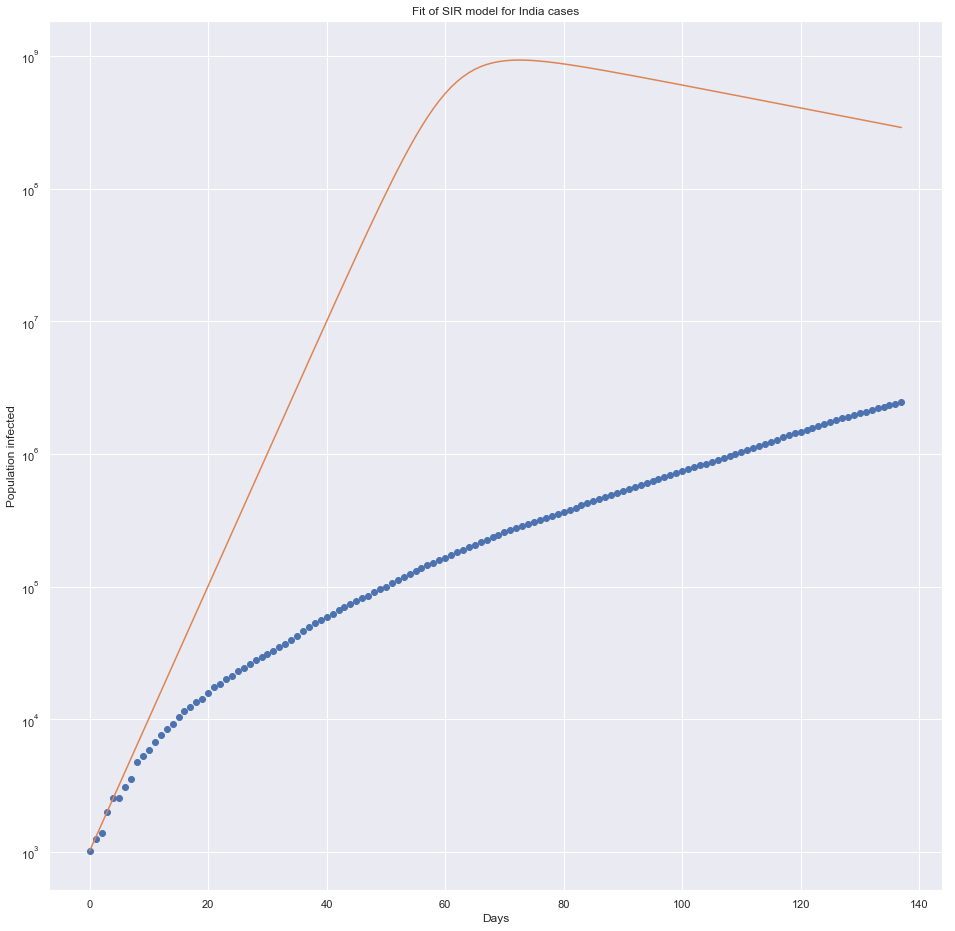

Optimal parameters: beta = 0.25  and gamma =  0.02
Basic Reproduction Number R0  12.5
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [42]:
hyderparamters = { 
        'ro' : popt['beta']/ popt['gamma'],
                  'beta': popt['beta'],
                  'gamma': popt['gamma']
                 }

plt.figure(figsize=(16, 16))
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for {} cases".format(country))
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt['beta'], " and gamma = ", popt['gamma'])
print("Basic Reproduction Number R0 " , popt['beta']/ popt['gamma'])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

Parameter finding using grid search cv is a hectic search but no assurance of global values

# Search function using optimization algorthim
###### Instead of a hectic and manual parameter search, a optimization algorithm , PSO (Particle swarm optimizaton ) is considered

In [43]:
print('Country - {}, Population: {}, Initial infected: {}, Suspected: {}, Recovered: {}'.format(country, N0, I0, S0, R0))

Country - India, Population: 1300000000, Initial infected: 1024, Suspected: 1299998976, Recovered: 0


In [44]:
%run ../src/data/search_function.ipynb # run search function 
popt, _ , jk= search_function()
# Gbest is a global best value and gets updated if a new best value is found

GBEST : [1.6974844  1.82069983]
GBEST : [1.26190213 1.26807243]
GBEST : [1.42443624 1.40674665]
GBEST : [1.44357604 1.35931962]
GBEST : [0.84865924 0.7956421 ]
GBEST : [0.79458368 0.74141781]
GBEST : [0.68864893 0.63548306]
GBEST : [1.08028582 1.02100002]
GBEST : [1.08664893 1.02603549]
GBEST : [0.9506759  0.88447952]
GBEST : [0.94630976 0.88481135]
GBEST : [0.94769514 0.88526955]
GBEST : [0.94811484 0.88472717]
GBEST : [1.19775158 1.13016863]
GBEST : [1.19763454 1.13047144]
GBEST : [1.19765582 1.13093698]
GBEST : [1.19765689 1.13095188]
GBEST : [1.19765608 1.13094498]
GBEST : [1.19765588 1.13095098]
GBEST : [1.19765595 1.13094879]
GBEST : [1.19765596 1.13094852]
GBEST : [1.1974899  1.13073357]
GBEST : [1.19748994 1.13073363]
GBEST : [1.19749232 1.13080512]
GBEST : [1.1975057  1.13080121]
GBEST : [1.19750359 1.13080183]
GBEST : [1.19750373 1.13080083]
GBEST : [1.1975037  1.13080065]
GBEST : [1.19750371 1.13080054]
GBEST : [1.19750371 1.13080054]
GBEST : [1.19750371 1.13080053]
GBEST : 

In [45]:
# run with obtained values
popt = popt.tolist()

fitted=fit_odeint(t, *popt)

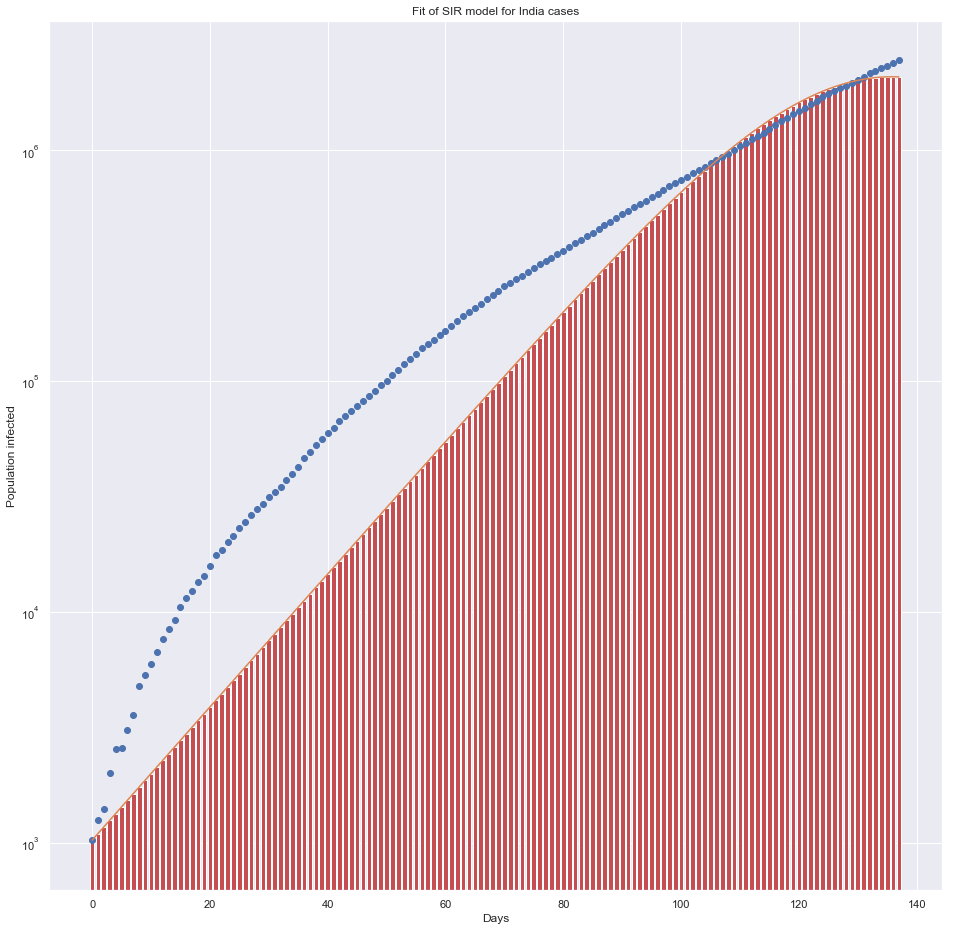

Optimal parameters: beta = 1.1859308459146851  and gamma =  1.1194391296994295
Basic Reproduction Number R0  1.0593973485928696
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [46]:
hyderparamters = { 'ro' : popt[0]/ popt[1],
                  'beta': popt[0],
                  'gamma': popt[1]
                 }
plt.figure(figsize=(16, 16))
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.bar(np.arange(len(ydata)),fitted, width=0.8,label=' current infected India',color='r')
plt.title("Fit of SIR model for {} cases".format(country))
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In order to reduce the hectic hyperparameter search, a meta-heuristic optimization method is considred to find best paramters. As from the above plot, the fit curve doesnot fit precisely with the data

# Interval data fit

In [55]:
# initalize values
beta=0.4
gamma=0.4
print('Country - {}, Population: {}, Initial infected: {}, Suspected: {}, Recovered: {}'.format(country, N0, I0, S0, R0))

Country - India, Population: 1300000000, Initial infected: 1024, Suspected: 1299998976, Recovered: 0


In [56]:
# interval wise fit
interval_fitted = np.array([])
SIR=np.array([S0,I0,R0])
interval = 7 # interval for fit

r_value = []
for i in range(len(ydata)):
    interval_data = ydata[i*interval:(i*interval)+interval]
    interval_t = np.arange(len(interval_data))
    
    if(interval_data.size != interval_t.size or interval_data.size==0):
        break

    #Re-initialize SIR for each interval
    I0=interval_data[0] #Initial infected
    S0=N0-I0 #Susceptible people
    R0=SIR[2] #Recovered
    
    print("\n\nFitting curve from day - ",i*interval +1," to ", i*interval+ interval," with SIR - ",SIR)
    popt, pcov = optimize.curve_fit(fit_odeint,interval_t,interval_data,maxfev=1000)
    perr = np.sqrt(np.diag(pcov))
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

    # Recalculate SIR with new_delta
    new_delta = SIR_model(SIR,*popt)
    SIR = SIR + new_delta
    r_value.append(popt[0]/ popt[1])
    temp_fit = fit_odeint(interval_t,*popt)
    interval_fitted = np.hstack((interval_fitted, temp_fit))



Fitting curve from day -  1  to  7  with SIR -  [1299998976       1024          0]
Optimal parameters: beta = -107.2288428114652  and gamma =  -107.45611240302969
Basic Reproduction Number R0  0.9978850008018894


Fitting curve from day -  8  to  14  with SIR -  [ 1.30010878e+09  1.25681055e+03 -1.10035059e+05]
Optimal parameters: beta = 66.37784844608952  and gamma =  66.18422308570578
Basic Reproduction Number R0  1.002925551609679


Fitting curve from day -  15  to  21  with SIR -  [ 1.30002535e+09  1.50714153e+03 -2.68540291e+04]
Optimal parameters: beta = 27.936561713778204  and gamma =  27.828283164722325
Basic Reproduction Number R0  1.0038909532584153


Fitting curve from day -  22  to  28  with SIR -  [1.29998324e+09 1.67115356e+03 1.50871322e+04]
Optimal parameters: beta = -0.023970559808660835  and gamma =  -0.09035464895195124
Basic Reproduction Number R0  0.2652941501815572


Fitting curve from day -  29  to  35  with SIR -  [1.29998328e+09 1.78209209e+03 1.49361357e+04]

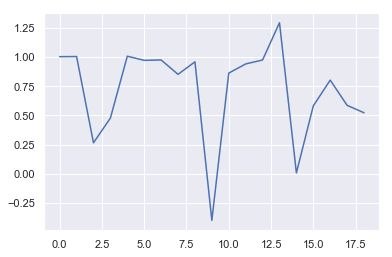

In [57]:
plt.plot(r_value[1:])

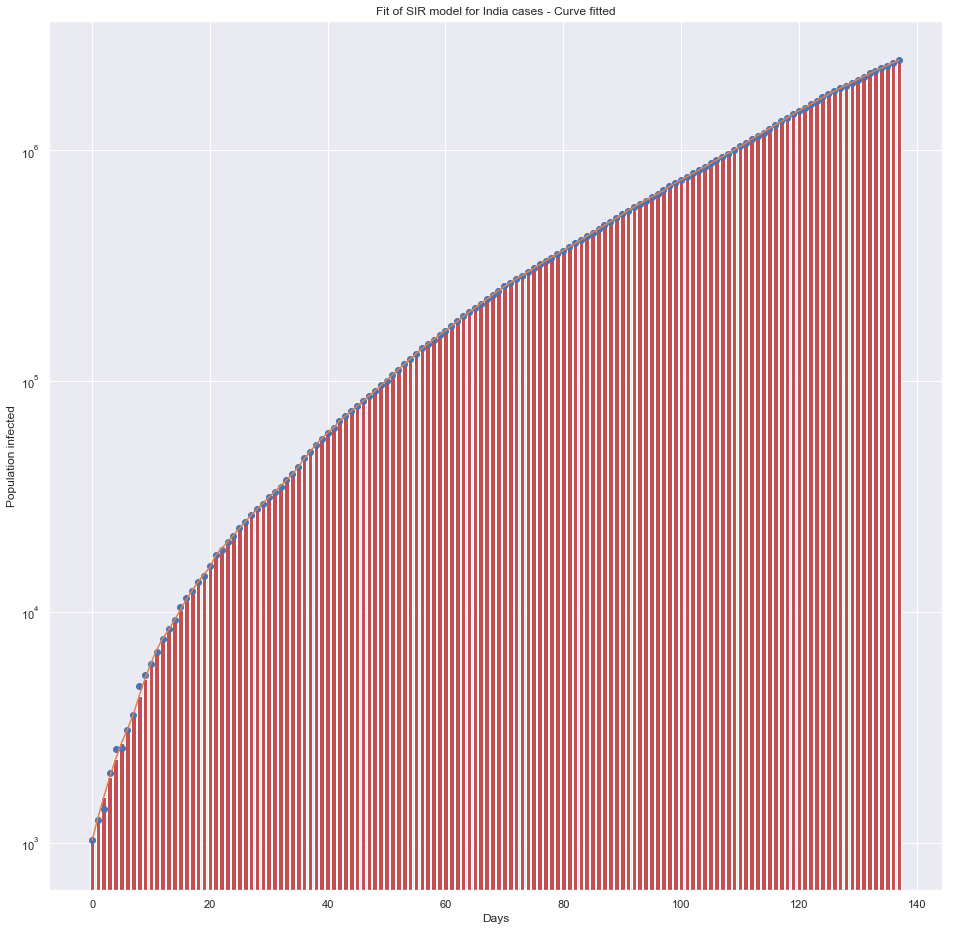

In [58]:
plt.figure(figsize=(16, 16))
plt.semilogy(t, ydata, 'o')
plt.semilogy(t[:interval_fitted.size], interval_fitted)
plt.bar(np.arange(len(ydata)),interval_fitted, width=0.8,label=' current infected India',color='r')
plt.title("Fit of SIR model for India cases - Curve fitted")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [14]:
# save results of ydata and fit data into dataframe
dynamic_model = pd.DataFrame()
ydata_column_name = '{}_ydata'.format(country)
fitted_column_name = '{}_fitted'.format(country)
dynamic_model[ydata_column_name] = ydata
dynamic_model[fitted_column_name] = interval_fitted

In [15]:
# # save as .csv to local
# dynamic_model.to_csv('../data/processed/SIR_dynamic.csv', sep=';',index=False)
# with open('../data/processed/hyderparamters.pkl', 'wb') as f:
#     pickle.dump(hyderparamters, f)

In [16]:
dynamic_model.tail(15)

,India_ydata,India_fitted
123,1634746,1.637844e+06
124,1695988,1.692614e+06
125,1750723,1.749174e+06
126,1803695,1.803695e+06
127,1855745,1.857250e+06
128,1908254,1.912391e+06
129,1964536,1.969164e+06
130,2027074,2.027617e+06
131,2088611,2.087799e+06
132,2153010,2.149763e+06


# Dashboard

In [18]:
import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


# Load processed file 
country = 'Germany'
df_plot=pd.read_csv('../data/processed/dynamic_model.csv', sep=';')  
# df_plot.reset_index(inplace=True)
# load ro, beta, gamma values as hyperparameters
# with open('../data/processed/hyderparamters.pkl', 'rb') as f:
#     hyperparamters = pickle.load(f)

    
## Dashboard visual board ##
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot.India_ydata,
                    mode='lines+markers', name='India',
                         marker=dict(
                     color='rgb(125, 178, 102)',
                     size=10,
                     line=dict(
                        color='DarkSlateGrey',
                        width=1
                      ),
                    
                         )))
              
# fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot.India_fitted,
#                     mode='lines+markers',
#                     name='India_simulated'))

fig.add_bar(x = df_plot.index, y=df_plot.India_fitted,
#                     mode='lines+markers',
                    name='India_simulated'
                    )




fig.update_layout(
    title='<b>SIR model Actual infection rate Vs Simulated model rate</b>',
    xaxis_title='No. of days',
    yaxis_title='No. of infected cases (non-log scale)',
    template = 'plotly_dark',
    font=dict(
         family='Verdana',
         size=16,
         color='white'
    )
)
fig.update_xaxes(showline=True,
                 linewidth=2,
                 linecolor='black',
                 mirror=True,
                 showgrid=False,
                 zerolinecolor='white',
                 zerolinewidth=1,
                 range=[0, 160])
fig.update_yaxes(showline=True,
                 linewidth=2,
                 linecolor='black',
                 mirror=True,
                 showgrid=True,
                 gridwidth=1,
                 gridcolor='grey',
                 zerolinecolor='black',
                 zerolinewidth=1,
#                  range=[-10000, 3000000]
                )
fig.show()
